# AlexNet 网络识别手写图片
本节属于 [PyTorch深度学习：深度神经网络（CNN）](https://www.bilibili.com/video/BV1vu4y1n77T) 的范畴，AlexNet 是第一个现代深度卷积网络模型，其首次使用了很多现代网络的技术方法，作为 2012 年 ImageNet 图像分类竞赛冠军，输入为 3×224×224 的图像，输出为 1000 个类别的条件概率。

这里跟随 B 站视频中的教学，拿来识别图片，因为 ImageNet 数据集太大训练时间过长，主要是体验一下网络构建的过程。



In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

# 数据集相关
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
transform = transforms.Compose(  # 将多个图像变换操作组合在一起
    [
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# 下载训练集
train_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=False,
    download=True,
    transform=transform
)

# 批次加载器
train_loader = DataLoader(train_data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_data, shuffle=False, batch_size=256)

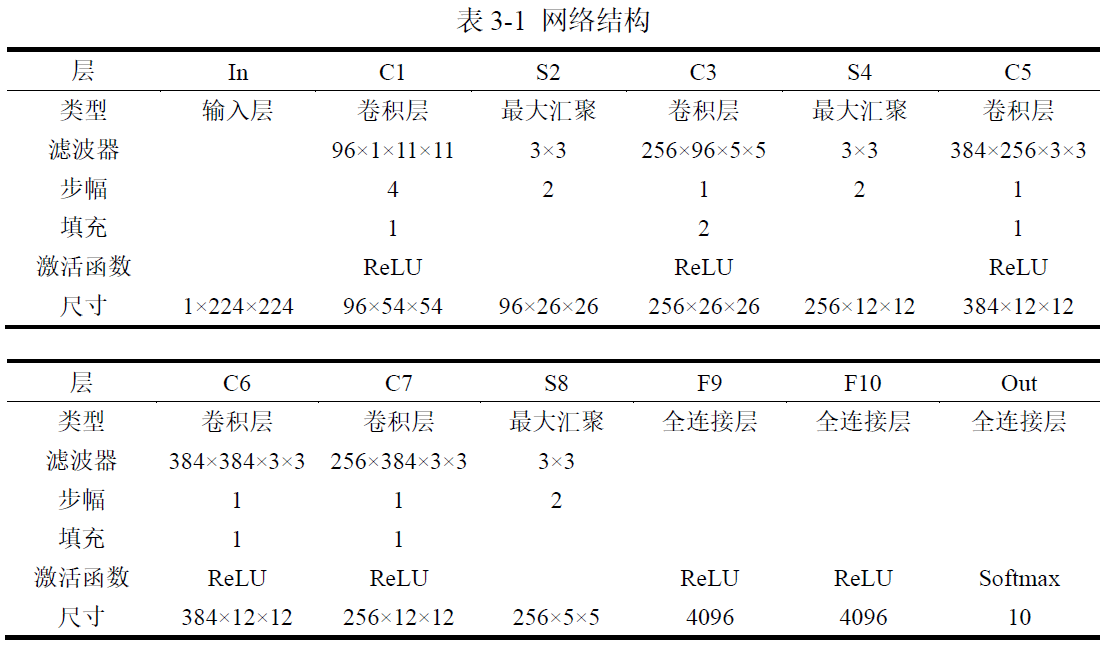

In [3]:
# 神经网络示意图
from IPython.display import Image

Image(filename='./images/AlexNet 网络.png')

In [4]:
# 上图中的表格相较于原 AlexNet 稍有修改，不过总体不变，仅输入输出做了改变
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=6400, out_features=4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=10)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
# 初始化网络与训练器
net = Net().to('cuda')

learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()  # 自带 softmax 激活函数

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

307.818473123014
26.661930222064257
14.436844404786825
10.44686798658222
8.328837839420885
6.7650570520199835
5.8987943100510165
4.759063144214451
4.390228346397635
3.7513505064998753


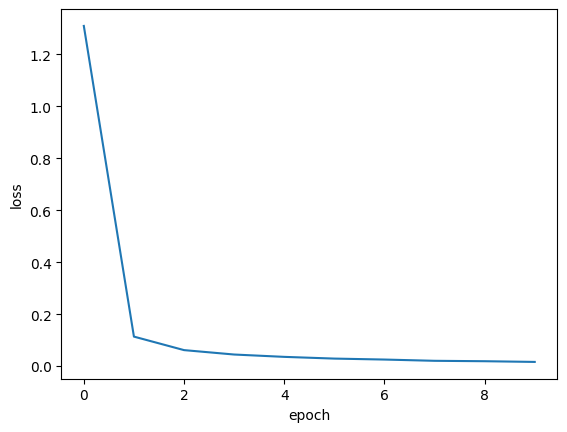

In [6]:
epochs = 10
losses = []

for epoch in range(epochs):
    avg_loss = 0
    times = 0

    for x, y in train_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        times += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(avg_loss)
    losses.append(avg_loss / times)

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [7]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():
    for (x, y) in test_loader:
        # 获取小批次的x与y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = net(x)
        # 该局部关闭梯度计算功能
        # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum((predicted == y))
        total += y.size(0)

print(f'测试集精准度: {100 * correct/total} %')

测试集精准度: 99.00999450683594 %


In [12]:
from tools.ipynb_draw import DrawCanvas
from IPython.display import display
from ipywidgets import Button
from PIL import Image

dc = DrawCanvas(width=48, height=48, brush_size=6)

callback_button = Button(description="识别")

def callback(_):
    with dc.out:
        try:
            np_img = dc.canvas.get_image_data(width=48, height=48)
            img = Image.fromarray(np_img)
            transform = transforms.Compose([
                transforms.Grayscale(),  # 如果是彩色图像转为灰度
                transforms.Resize((224, 224)),  # 调整大小为 224 * 224
                transforms.ToTensor(),  # 转为张量并归一化到[0,1]
                transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[-1,1]
            ])

            # 对图像进行预处理
            input_tensor = transform(img).unsqueeze(0).to('cuda')  # 添加batch维度 (1, 1, 28, 28)

            # 3. 前向传播
            with torch.no_grad():  # 不需要计算梯度
                output = net(input_tensor)
                prediction = torch.argmax(output, dim=1).item()  # 获取预测类别
                print(prediction)
        except BaseException as e:
            print(str(e))

callback_button.on_click(callback)


layout = dc.get_layout()
layout.children[1].children = layout.children[1].children + (callback_button,)
display(layout)